##Clipnorm

In [ ]:
def scale_from_d(d):
    mean = 1.5
    # Calculate the z-score
    z_score = norm.ppf(1/d)

    # Calculate the standard deviation
    scale = - mean / z_score
    return scale

## Norm distribution

In [ ]:
import numpy as np
from scipy import integrate
from scipy.stats import norm
from scipy.optimize import minimize
from tqdm.notebook import tqdm

# Define the normal distribution parameters
mean = 1.5
clipped = True
use_d_key = True

# Define the function sigma - sigma^2
def func(sigma, dist, shift):
    return dist * (sigma - shift) - (sigma - shift)**2
    #return sigma - sigma**2

def g_sigma(sigma, scale):
    return norm.pdf(sigma, mean, scale)  # Shifted by 0

# Define the integrand for each interval as the product of the function and the shifted pdf
def integrand1(sigma, lo, scale):
    return func(sigma, lo, 0) * g_sigma(sigma, scale)

def integrand2(sigma, lo, hi, scale):
    return func(sigma, (hi - lo), lo) * g_sigma(sigma, scale)

def integrand3(sigma, hi, scale):
    return func(sigma, (3 - hi), hi) * g_sigma(sigma, scale)

def expected_value_func(x, scale):
    lo = x[0]
    hi = x[1]
    

    total_weight = norm.cdf(3, mean, scale) - norm.cdf(0, mean, scale)
    if clipped:
        total_weight = 1
   
    # Calculate the weighted expected value by integrating the integrand over each range of sigma and summing
    expected_value = ((integrate.quad(integrand1, 0, lo, args=(lo, scale), limit=100)[0]) +
                      (integrate.quad(integrand2, lo, hi, args=(lo, hi, scale), limit=100)[0]) +
                      (integrate.quad(integrand3, hi, 3, args=(hi, scale), limit=100)[0])) / total_weight
    
    return expected_value

# Define the constraints with the fourth constraint
constraints_eq = ({'type': 'ineq', 'fun': lambda x:  x[0] - 0},  # lo > 0
                  {'type': 'ineq', 'fun': lambda x:  1.5 - x[0]})  # 1.5 > lo 

los = []
# Loop over the desired scales
if use_d_key:
    scales = scale_from_d(np.arange(4, 2048))
else:
    scales = np.arange(0.01, 5.0, 0.001)

# Get the cumulative probabilities at 0 and 3
cdf_0 = norm.cdf(0, loc=mean, scale=scales[0])
cdf_3 = norm.cdf(3, loc=mean, scale=scales[0])

# Compute the adjusted percentiles
p33_adjusted = norm.ppf(cdf_0 + 0.33*(cdf_3 - cdf_0), loc=mean, scale=scales[0])
p67_adjusted = norm.ppf(cdf_0 + 0.67*(cdf_3 - cdf_0), loc=mean, scale=scales[0])
x0 = np.array([p33_adjusted, p67_adjusted])

for idx, scale in tqdm(enumerate(scales), total=len(scales)):    
    # Optimize lo and hi for the current scale, first with the fourth constraint
    res = minimize(expected_value_func, x0, args=(scale), method='L-BFGS-B')
    uniform_res = expected_value_func([1.0, 2.0], scale)

    los.append(res.x[0])
    # Print the optimal lo and hi and the corresponding expected value
    print(f"{idx+4}: For scale {scale:.2f}, optimal lo = {res.x[0]:.3f}, hi = {(3 - res.x[0]):.3f}, expected value = {res.fun:.5f}, , non-opt value = {uniform_res:.5f}")

    x0 = res.x
    if res.x[0] < 1.01:
        break

In [ ]:
norm_scales = scales
norm_los = los
ds = np.arange(4, 2048)

In [ ]:
len(ds)

2044

In [ ]:
import pandas as pd

# After your loop
df = pd.DataFrame({
    'dim': ds,
    'norm_scales': norm_scales,
    'norm_los': norm_los,
    'clipped_scales': scales,
    'clipped_los': los,
})

df.to_csv('lo_data.csv', index=False)

In [ ]:
len(scales)

2044

In [ ]:
scales = np.arange(4, 2048, dtype=float)

<ipython-input-12-13b5b4a6b304>:8: RuntimeWarning: invalid value encountered in log
  return a + b * np.log(x * c) + d * x + f * x**0.5


Fitted function: lo = 0.83162565 + 0.02993653 * np.log(x * 116.05528511) + 0.00001225 * x + -0.00171617 * x**0.5
[ 8.31625650e-01  2.99365309e-02  1.16055285e+02  1.22537137e-05
 -1.71617370e-03]


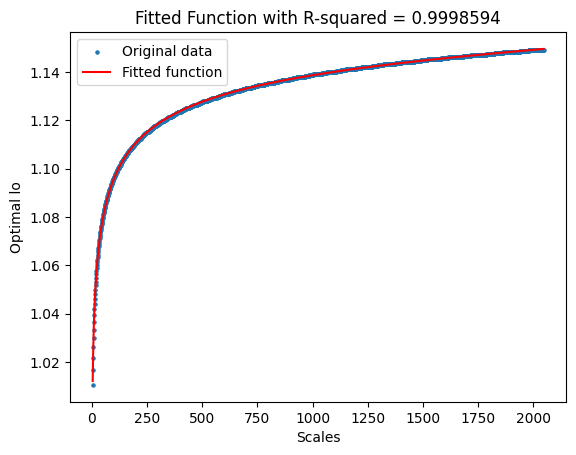

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# define the model function
def func(x, a, b, c, d, f):
    return a + b * np.log(x * c) + d * x + f * x**0.5

# Fit the model to the data
initial_guess = [1, 1, 1, 1, 1]  # Initial guess for the coefficients
popt, pcov = curve_fit(func, scales, los, p0=initial_guess)

# Build the string representation of the fitted function
func_str = f"Fitted function: lo = {popt[0]:.8f} + {popt[1]:.8f} * np.log(x * {popt[2]:.8f}) + {popt[3]:.8f} * x + {popt[4]:.8f} * x**0.5"
print(func_str)
print(popt)

# Compute predicted values from fitted function
y_pred = func(scales, *popt)

# Compute r-squared value
r2 = r2_score(los, y_pred)

# Plot original data
plt.scatter(scales, los, label='Original data', s=5)

# Plot fitted function
plt.plot(scales, y_pred, 'r', label='Fitted function')

plt.xlabel('Scales')
plt.ylabel('Optimal lo')
plt.legend()
plt.title(f'Fitted Function with R-squared = {r2:.7f}')
plt.show()


Fitted function: lo = -0.000*scale^4 + 0.000*scale^3 + -0.000*scale^2 + 0.000*scale + 1.094 + -0.869/scale + 2.323/scale^2
[-1.39980419e-14  7.19734577e-11 -1.36218956e-07  1.24159347e-04
  1.09360979e+00 -8.69114078e-01  2.32298943e+00]


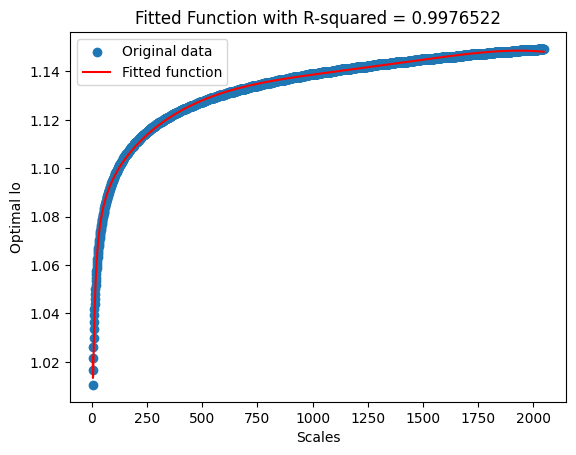

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


def poly_n(x, *coefficients):
    # Create an array of powers (including negative ones)
    powers = np.arange(len(coefficients) - 3, -3, -1)
    # Compute each term of the polynomial and sum them up
    return sum(coef * x**power for coef, power in zip(coefficients, powers))

weights = np.exp(-((scales - np.mean(scales) - 0.6) / (3 * np.std(scales)))**2)

# Fit the polynomial to the data
initial_guess = [0] * 7  # Initial guess for the coefficients
popt, pcov = curve_fit(poly_n, scales, los, p0=initial_guess)#, sigma=1.0/weights)

# Create an array of powers (including negative ones)
powers = np.arange(len(popt) - 3, - 3 , -1)

# Build the string representation of the fitted polynomial
poly_str = "Fitted function: lo = "
for coef, power in zip(popt, powers):
    if power == 0:
        poly_str += f"{coef:.3f} + "
    elif power == -1:
        poly_str += f"{coef:.3f}/scale + "
    elif power == -2:
        poly_str += f"{coef:.3f}/scale^2 + "
    elif power == 1:
        poly_str += f"{coef:.3f}*scale + "
    else:
        poly_str += f"{coef:.3f}*scale^{power} + "

print(poly_str.rstrip(' + '))
print(popt)


# Compute predicted values from fitted function
y_pred = poly_n(scales, *popt)

# Compute r-squared value
r2 = r2_score(los, y_pred)

# Plot original data
plt.scatter(scales, los, label='Original data')

# Plot fitted function
plt.plot(scales, y_pred, 'r', label='Fitted function')

plt.xlabel('Scales')
plt.ylabel('Optimal lo')
plt.legend()
plt.title(f'Fitted Function with R-squared = {r2:.7f}')
plt.show()


In [ ]:
def compute_lo(scale):
    # Replace these coefficients with the ones you obtained from curve fitting
    coefficients = [8.93135041e-05, -2.16343898e-03,  2.23533211e-02, -1.28729900e-01,
                    4.53149465e-01, -1.00553436e+00,  1.39518353e+00, -1.14392589e+00,
                    1.45688414e+00,  8.39247367e-04, -5.60853472e-06]  # Replace with the printed popt array

    # Create an array of powers (including negative ones)
    powers = np.arange(len(coefficients) - 3, -3, -1)
    
    # Compute each term of the polynomial and sum them up
    lo = sum(coef * scale**power for coef, power in zip(coefficients, powers))
    
    return lo

In [ ]:
for scale in scales:
    print(scale, compute_lo(scale))
    if compute_lo(scale) < 1.01:
        break

0.7580645161290321


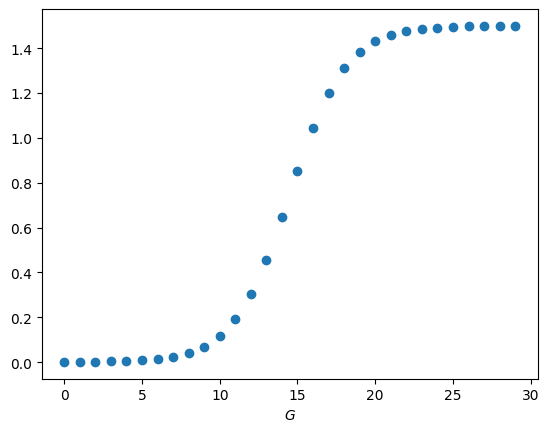

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of points you want to generate
n_points = 30

# Start and end points
start = 0.001
end = 1.499

# Create the values with linspace first
values = np.linspace(-1, 1, n_points)

# Now adjust the distribution with arctanh
# We also need to normalize the values back to the range between -1 and 1
sharpness = 4
values = np.tanh(sharpness * values)

# Scale the range from [start, end]
mn, mx = values.min(), values.max()
values = (values - mn) / (mx - mn) * 1.498 + start
print(np.mean(np.r_[values, 1]))

# Plot to see the distribution
plt.scatter(np.arange(30), values)
plt.xlabel('$G$')

plt.savefig('G_out.png', dpi=300)